In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [26]:
import numpy as np
import pandas as pd
import os
import time
import copy
import random
import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as data_utils
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split

# For image-keypoints data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import imgaug

In [70]:
train_df_path = './1. open/train_df.csv'

seed = 42
device = "cuda"    

# Number of classes in the dataset
num_classes = 48

# Learning rate for optimizer
lr = 1e-3

# Number of epochs and earlystop to train for
num_epochs = 50
train_batch_size = 24
valid_batch_size = 24
test_batch_size = 24
num_workers = 8
tta = True
tta_count = 32

folds = 5

# Iput size for resize imgae
input_w = 480
input_h = 270

In [36]:
train_df = pd.read_csv(train_df_path)
train_df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


In [37]:
# device 설정
device = torch.device(device if torch.cuda.is_available() else "cpu")

# seed 설정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    imgaug.random.seed(seed)

seed_everything(seed)

In [65]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=3):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)


In [66]:
# train, valid folder 속 모든 이미지 파일 read & sort
train_paths = glob.glob('./1. open/train_imgs/*.jpg')
train_paths.sort()

In [67]:
imgs = train_df.iloc[:, 0].to_numpy()
keypoint = train_df.iloc[:, 1:] 

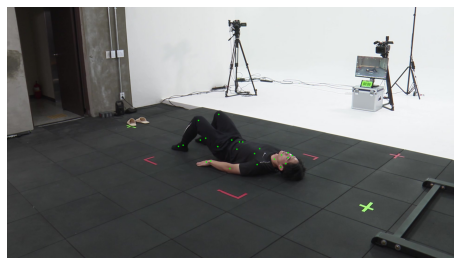

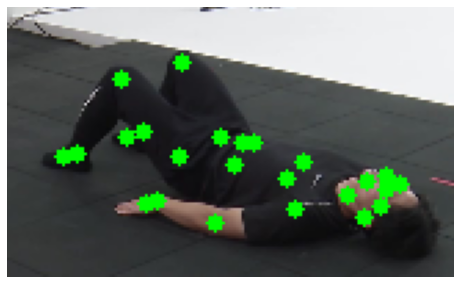

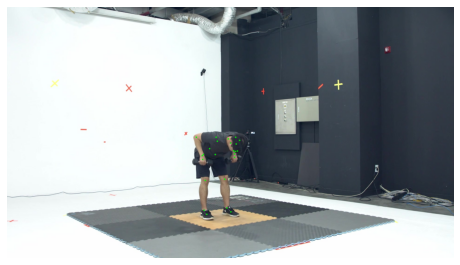

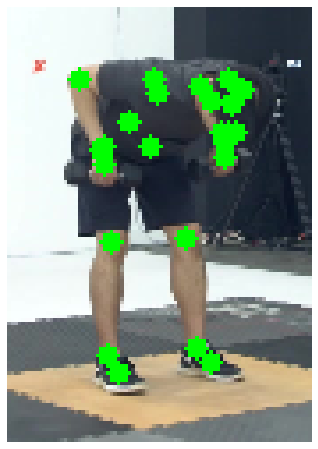

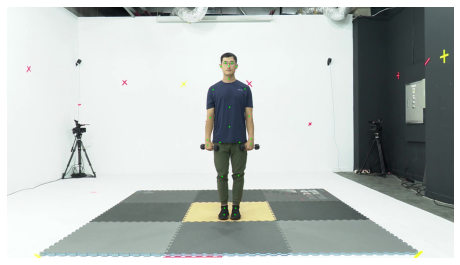

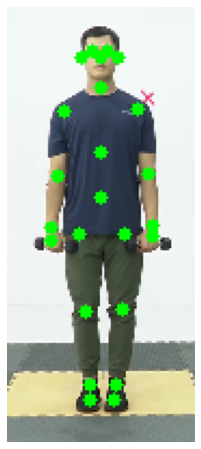

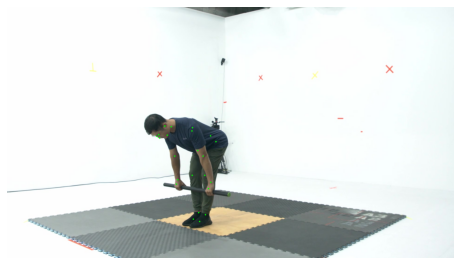

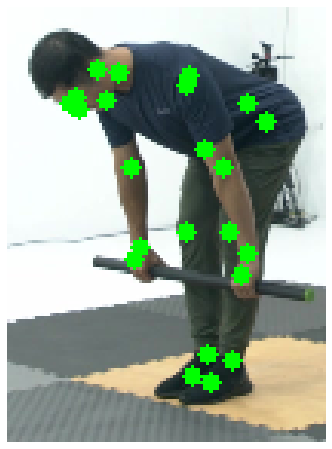

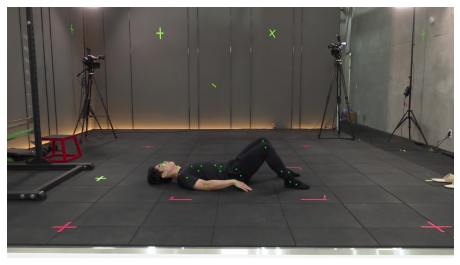

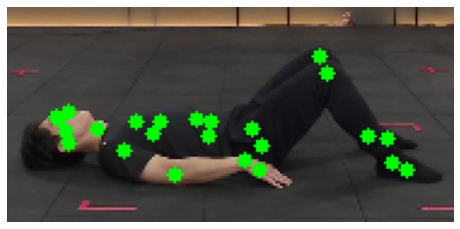

In [73]:
for i in np.random.randint(0,len(train_paths),5):
    image = cv2.imread(train_paths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_keypoint = keypoint.iloc[i, :].values.reshape(-1, 2)
    sample_keypoint = sample_keypoint.astype(np.int64)
    vis_keypoints(image, sample_keypoint)
    
    x_min, y_min = int(min(sample_keypoint[:, 0])/4)-20, int(min(sample_keypoint[:, 1])/4)-20
    x_max, y_max = int(max(sample_keypoint[:, 0])/4)+20, int(max(sample_keypoint[:, 1])/4)+20
    transform = A.Compose(
        [A.Resize(input_h, input_w, always_apply=True),
         A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, p=1)
        ], 
        keypoint_params=A.KeypointParams(format='xy')
    )
    transformed = transform(image=image, keypoints=sample_keypoint)
    vis_keypoints(transformed['image'], transformed['keypoints'])

In [74]:
class Dataset(data_utils.Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, keypoints,class_labels=None, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.keypoints = keypoints
        self.class_labels = class_labels
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))
        keypoints = self.keypoints.iloc[idx, :].values.reshape(-1, 2).astype(np.int64)
    
        x_min, y_min = int(min(sample_keypoint[:, 0])/4)-20, int(min(sample_keypoint[:, 1])/4)-20
        x_max, y_max = int(max(sample_keypoint[:, 0])/4)+20, int(max(sample_keypoint[:, 1])/4)+20
    
        if self.data_transforms:
            
            transforms = A.Compose([
            A.Resize(input_h, input_w, always_apply=True),
            A.OneOf([A.HorizontalFlip(p=1),
                     A.RandomRotate90(p=1),
                     A.VerticalFlip(p=1)], p=0.5),
            A.OneOf([A.MotionBlur(p=1),
                     A.GaussNoise(p=1)], p=0.5),
            A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
            ],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            keypoint_params=A.KeypointParams(format='xy')
            )

            augmented = self.data_transforms(image=img, keypoints=keypoints, class_labels=self.class_labels)
            img = augmented['image']
            img = (img/255).astype('float')
            keypoints = augmented['keypoints']
        keypoints = np.array(keypoints).flatten()

        return img, keypoints
    
    def __len__(self):
        return len(self.imgs)

In [76]:
class AdamModel(nn.Module):
    def __init__(self):
        super(AdamModel, self).__init__()
        self.conv2d = nn.Conv2d(1, 3, 3, stride=1, padding=1)
        self.efn_b3 = timm.create_model('efficientnet_b3', pretrained=True, num_classes=1024)
        self.fc = nn.ModuleList([nn.Linear(1024, 1) for i in range(26)])

        nn.init.xavier_uniform_(self.conv2d.weight)
        for i in range(48):
            nn.init.xavier_uniform_(self.fc[i].weight)

    def forward(self, x):
        x = F.relu(self.conv2d(x))
        x = F.relu(self.efn_b3(x))
        xs = []
        for i in range(48):
            xs.append(self.fc[i](x))
        x = torch.cat(xs, dim=1)
        x = torch.sigmoid(x)
        return x

In [ ]:
# cross validation을 적용하기 위해 KFold 생성
from sklearn.model_selection import KFold
kfold = KFold(n_splits=config.folds, shuffle=True, random_state=0)

# dirty_mnist_answer에서 train_idx와 val_idx를 생성
best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(train_paths),1):
    print(f'[fold: {fold_index}]')
    '''
    실제로 colab에서 학습할 때에는 시간 절약을 위해 fold별로 여러 session을 열어두고 병렬 작업을 수행했습니다.
    각각의 fold 작업에서 동일한 seed로 작업이 진행되기 때문에 이 코드에서 제출 결과를 재현하기 위해서는
    seed 초기화가 필요할 수 있습니다.

    seed_everything(config.seed)
    ''' 
    # cuda cache 초기화
    torch.cuda.empty_cache()

    #train fold, validation fold 분할
    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer  = dirty_mnist_answer.iloc[val_idx]

    #Dataset 정의
    train_dataset = DatasetMNIST(config.TRAIN_DATA_PATH, train_answer, augmentations=True)
    valid_dataset = DatasetMNIST(config.TRAIN_DATA_PATH, test_answer)

    #DataLoader 정의
    train_data_loader = DataLoader(
        train_dataset,
        batch_size = config.train_batch_size,
        shuffle = False,
        num_workers = config.num_workers
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = config.valid_batch_size,
        shuffle = False,
        num_workers = config.num_workers
    )

    # 모델 선언
    model = AdamModel()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)# gpu에 모델 할당

    # 훈련 옵션 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.85)
    criterion = torch.nn.BCELoss()

    # 훈련 시작
    valid_acc_max = 0
    early_stop_count = 0
    for epoch in range(config.epochs):
        # 1개 epoch 훈련
        train_acc_list = []
        with tqdm(train_data_loader,#train_data_loader를 iterative하게 반환
                total=train_data_loader.__len__(), # train_data_loader의 크기
                unit="batch") as train_bar:# 한번 반환하는 smaple의 단위는 "batch"
            for sample in train_bar:
                train_bar.set_description(f"Train Epoch {epoch}")
                # 갱신할 변수들에 대한 모든 변화도를 0으로 초기화
                # 참고)https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                # tensor를 gpu에 올리기 
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 train 모드로 설정
                model.train()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.set_grad_enabled(True):
                    # 모델 예측
                    probs  = model(images)
                    # loss 계산
                    loss = criterion(probs, labels)
                    # 중간 노드의 gradient로
                    # backpropagation을 적용하여
                    # gradient 계산
                    loss.backward()
                    # weight 갱신
                    optimizer.step()

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)

                # 현재 progress bar에 현재 미니배치의 loss 결과 출력
                train_bar.set_postfix(train_loss= loss.item(),
                                        train_acc = train_acc)
                

        # 1개 epoch학습 후 Validation 점수 계산
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit="batch") as valid_bar:
            for sample in valid_bar:
                valid_bar.set_description(f"Valid Epoch {epoch}")
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 eval모드로 설정
                model.eval()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.no_grad():
                    # validation loss만을 계산
                    probs  = model(images)
                    valid_loss = criterion(probs, labels)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                        valid_acc = valid_acc)
            
        # Learning rate 조절
        lr_scheduler.step()

        # 모델 저장
        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            early_stop_count = 0
            best_model = model
            MODEL = config.ADAM_MODEL_PREFIX
            # 모델을 저장할 구글 드라이브 경로
            path = config.ADAM_MODEL_PATH
            torch.save(best_model, f'{path}{fold_index}_{MODEL}.pth')
        else:
            early_stop_count += 1
            if early_stop_count > 5:
                print(f'early stopped at epoch: {epoch}')
                break

    # 폴드별로 가장 좋은 모델 저장
    best_models.append(best_model)